# Práctica Análisis de Sentimientos

Para esta práctica se proporciona el corpus “reviews_filmaffinity.csv” que contiene 1882 criticas
de películas obtenidas de la web de Filmaffinity. 

El contenido de este corpus es el siguiente:

• film_name: Nombre de la película

• film_avg_rate: Valoración media de la película de 1 a 10 (voto de todos los usuarios).

• review_rate: Valoración de la película (1-10) por parte del usuario que redacta la crítica.

• review_title: Título de la crítica.

• review_text: Crítica de la película.




<hr>

# Planteamiento

* En el siguiente ejercicio tiene como objetivo aplicar los conocimientos vistos hasta el momento de:
    - Normalización de textos (procesamiento de textos)
    - Clasificación de textos
    
    
* El ejercicio consiste en clasificar una serie de tweets en Español que estan clasificados como '***positivos***', '***neutros***', '***negativos***' o '***None***' (desconocido), aunque solo vamos a trabajar con los tweets clasificados correctamente (los no desconocidos).


* Para este ejercicio se pide realizar todo el proceso de clasificación visto hasta el momento:
    1. Carga de los datos (ya implementado en el ejercicio)
    2. Normalización de los tweets
    3. Creacción de la Bolsa de Palabras
    4. Particionado de Datos
    5. Creacción de modelos
    6. Evaluación de los modelos


* Los puntos del 2 al 6 son los que hay que realizar con los visto hasta el momento.

<hr>

# Solucion

In [1]:
import pandas as pd
tweets_file = 'C:/Users/juanS/OneDrive/Escritorio/reviews_filmaffinity.csv'
df = pd.read_csv(tweets_file, sep="\|\|", names=['film_name','film_avg_rate', 'review_rate', 'review_title', 'review_text'], header=1, engine='python')
#df = df[df['sentimiento'].isin(['positivo', 'neutro', 'negativo'])]
#tweets = [tuple(x) for x in df.values]
#print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))
df.head(5)

,film_name,film_avg_rate,review_rate,review_title,review_text
0,Ocho apellidos vascos,"6,1",2,El perro verde,"No soy un experto cinéfilo, pero pocas veces m..."
1,Ocho apellidos vascos,"6,1",2,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...
2,Ocho apellidos vascos,"6,1",2,Aida: The movie,"No sé qué está pasando, si la gente se deja ll..."
3,Ocho apellidos vascos,"6,1",2,UN HOMBRE SOLO (Julio Iglesias 1987),"""Pero cuando amanece,y me quedo solo,siento en..."
4,Ocho apellidos vascos,"6,1",8,Iñaki el metralleta,La llegada de Rafa a Euskadi es como ponerse a...


## Creamos una columna que categorize los valores de los votos por usuario

In [2]:
pd.cut(df['review_rate'], bins=[0,4,6,10], labels=[1, 2, 3])

0       1
1       1
2       1
3       1
4       3
       ..
1876    3
1877    3
1878    3
1879    3
1880    1
Name: review_rate, Length: 1881, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [3]:
df['sentiment'] = pd.cut(df['review_rate'], bins=[0,4,6,10], labels=[1, 2, 3])

In [4]:
df2 = df.copy()

# realice una copia para ser mas practico ante cualquier modificacion

In [5]:
# Eliminamos las variables review_rate y review_title para simplificar el modelo
df2.drop(columns=["review_rate","review_title"], inplace=True)

df2.head()

,film_name,film_avg_rate,review_text,sentiment
0,Ocho apellidos vascos,"6,1","No soy un experto cinéfilo, pero pocas veces m...",1
1,Ocho apellidos vascos,"6,1",Si no eres un incondicional del humor estilo T...,1
2,Ocho apellidos vascos,"6,1","No sé qué está pasando, si la gente se deja ll...",1
3,Ocho apellidos vascos,"6,1","""Pero cuando amanece,y me quedo solo,siento en...",1
4,Ocho apellidos vascos,"6,1",La llegada de Rafa a Euskadi es como ponerse a...,3


In [6]:
print("=" * 12)
print("Negativos = 1")
print("Neutros = 2")
print("Positivos = 3")
print("=" * 12)

Negativos = 1
Neutros = 2
Positivos = 3


In [7]:
cantidad = df2[["sentiment"]].value_counts()
porcentaje = cantidad/1881

print('--------------------------')
print('probabilidad P(sentiment/total de votos)')
print('--------------------------')
print (porcentaje)

--------------------------
probabilidad P(sentiment/total de votos)
--------------------------
sentiment
3            0.459330
1            0.298777
2            0.241893
dtype: float64


C:\Users\juanS\anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 7'. Pick better value with 'binwidth'.


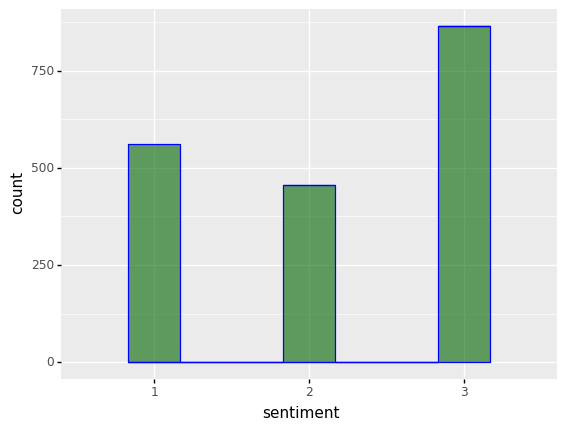

<ggplot: (153261380274)>

In [8]:
from plotnine import *
(
    ggplot(df2) +
     geom_histogram(aes(x='sentiment'), fill = 'darkgreen', color = 'blue', alpha = 0.6 )
)

## La poblacion esta desvalanceado, dado esto, no podemos utilizar metricas como Accuracy. Por lo tanto nos fiamos en Presicion y Recall

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

# limpieza y preprocesamiento de los datos.

## Normalización

In [9]:
tweets = [tuple(x) for x in df2.values]
print('Número de Tweets Cargados: {num}'.format(num=len(tweets)))

Número de Tweets Cargados: 1881


In [10]:
import spacy

from tqdm import tqdm #used for creating Progress Meters or Progress Bars

nlp = spacy.load('es_core_news_sm')

# Divido los datos en dos listas 
#     X: los tweets
#     y: target (polaridad)

X = [doc[2] for doc in tweets]
y = [doc[3] for doc in tweets] #???? o df2['sentiment'] = y

def normalize(sentenses):
    """normalizamos la lista de frases y devolvemos la misma lista de frases normalizada"""
    for index, sentense in enumerate(tqdm(sentenses)):
        sentense = nlp(sentense.lower()) # Paso la frase a minúsculas y a un objeto de la clase Doc de Spacy
        sentenses[index] = " ".join([word.lemma_ for word in sentense if (not word.is_punct)
                                     and (len(word.text) > 2) and (not word.is_stop)
                                     and (not word.text.startswith('@'))
                                     and (not word.text.startswith('http'))])
    return sentenses



# Normalizamos las frases
X = normalize(X)

100%|██████████| 1881/1881 [00:48<00:00, 38.72it/s]


## Intente realizar el BoW con el Count Vctorizer y el tfidf Vectorizer. Obteniendo mejores resultados con el Segundo metodo.

In [11]:
#from sklearn.feature_extraction.text import CountVectorizer

#vectorizer = CountVectorizer(max_features=2000, min_df=3)

# Pasamos los tweets normalizados a Bolsa de palabras
#X = vectorizer.fit_transform(X)

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)



In [13]:
# el compressed sparse row format es debido al CountVectorizer
X[1]

<1x18555 sparse matrix of type '<class 'numpy.float64'>'
	with 59 stored elements in Compressed Sparse Row format>

In [14]:
y[1]

1

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## Dividir el corpus en corpus de entrenamiento y de test (80% - 20% respectivamente).

* Particionar los datos en conjunto de Train y Test de la siguiente manera:
    - 80% de datos de entrenamiento
    - 20% de datos de test

In [15]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('Número de Tweets para el entrenamiento: {num}'.format(num=X_train.shape[0]))
print('Número de Tweets para el test: {num}'.format(num=X_test.shape[0]))

Número de Tweets para el entrenamiento: 1504
Número de Tweets para el test: 377



## Creacción del Modelo

* Vamos a crear una serie de modelos con los siguientes Algoritmos de Aprendizaje de clasificación:

    - Multinomial Naive Bayes
    - Bernoulli Naive Bayes
    - Regresion Logistica
    - Support Vector Machine
    - Random Forest

In [16]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

mnb = MultinomialNB()
bnb = BernoulliNB()
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)
svm_lin = SVC(kernel='linear')
svm_rbf = SVC(kernel='rbf')
rf = RandomForestClassifier(n_estimators=200, bootstrap=True, criterion='gini', max_depth=50, random_state=0)

clasificadores = {'Multinomial Naive Bayes': mnb,
                  'Bernoulli Naive Bayes': bnb,
                  'Regresion Logistica': lr,
                  'SVM lineal': svm_lin,
                  'SVM rbf': svm_rbf,
                  'Random Forest': rf}


# Ajustamos los modelos y calculamos el accuracy para los datos de entrenamiento
for k, v in clasificadores.items():
    print ('CREANDO MODELO: {clas}'.format(clas=k))
    v.fit(X_train, y_train)
    accuracy_train = v.score(X_train, y_train)
    print ('\tAccuracy Train: {acc_train}'.format(acc_train=accuracy_train)) 

CREANDO MODELO: Multinomial Naive Bayes
	Accuracy Train: 0.6030585106382979
CREANDO MODELO: Bernoulli Naive Bayes
	Accuracy Train: 0.769281914893617
CREANDO MODELO: Regresion Logistica
	Accuracy Train: 0.9315159574468085
CREANDO MODELO: SVM lineal
	Accuracy Train: 0.9714095744680851
CREANDO MODELO: SVM rbf
	Accuracy Train: 0.9940159574468085
CREANDO MODELO: Random Forest
	Accuracy Train: 0.9860372340425532


#### El mayor resultadoen accuracy para los modelos es 99,4% para SVM y 98,6% para Random forest 

<hr>


## Evaluación del Modelo

* Para cada uno de los modelos vamos a calcular las siguientes métricas de evaluación:

    1. **Accuracy** (No se recomienda para muestras desbalanceadas)
    2. **Precision**
    3. **Recall**
    4. **F1**

In [17]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

def evaluation(model, name, X_train, y_train, X_test, y_test):
    """
    Función de devuelve en un diccionario las métricas de evaluación de 
    Accuracy, Precision, Recall y F1 para los conjuntos de datos de entrenamiento y test
        model: modelo a evaluar
        name: nombre del modelo
        X_train: Variables de entrada del conjunto de datos de entrenamiento
        y_train: Variable de salida del conjunto de datos de entrenamiento
        X_test: Variables de entrada del conjunto de datos de test
        y_test: Variable de salida del conjunto de datos de test
        return: diccionario con el nombre del modelo y el valor de las métricas
    """
    model_dict = {}
    model_dict['name'] = name
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    model_dict['accuracy_train'] = accuracy_score(y_true=y_train, y_pred=y_pred_train)
    model_dict['accuracy_tests'] = accuracy_score(y_true=y_test, y_pred=y_pred_test)
    model_dict['precision_train'] = precision_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['precision_tests'] = precision_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['recall_train'] = recall_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['recall_tests'] = recall_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    model_dict['f1_train'] = f1_score(y_true=y_train, y_pred=y_pred_train, average='weighted')
    model_dict['f1_tests'] = f1_score(y_true=y_test, y_pred=y_pred_test, average='weighted')
    
    return model_dict


# Calculamos las métricas de los modelos por separado
evaluacion = list()
for key, model in clasificadores.items():
    evaluacion.append(evaluation(model=model, name=key, 
                                 X_train=X_train, y_train=y_train,
                                 X_test=X_test, y_test=y_test))

# Pasamos los resultados a un DataFrame para visualizarlos mejor
results = pd.DataFrame.from_dict(evaluacion)
results.set_index("name", inplace=True)
results

,accuracy_train,accuracy_tests,precision_train,precision_tests,recall_train,recall_tests,f1_train,f1_tests
name,,,,,,,,
Multinomial Naive Bayes,0.603059,0.435013,0.778652,0.466666,0.603059,0.435013,0.521122,0.295509
Bernoulli Naive Bayes,0.769282,0.541114,0.810181,0.578243,0.769282,0.541114,0.752323,0.502104
Regresion Logistica,0.931516,0.647215,0.937370,0.634518,0.931516,0.647215,0.929786,0.607479
SVM lineal,0.971410,0.633952,0.972259,0.616887,0.971410,0.633952,0.971088,0.613022
SVM rbf,0.994016,0.604775,0.994069,0.603831,0.994016,0.604775,0.994001,0.535825
Random Forest,0.986037,0.591512,0.986437,0.611666,0.986037,0.591512,0.986035,0.524729


* Representamos las métricas para los diferentes modelos en un gráfico de barras:

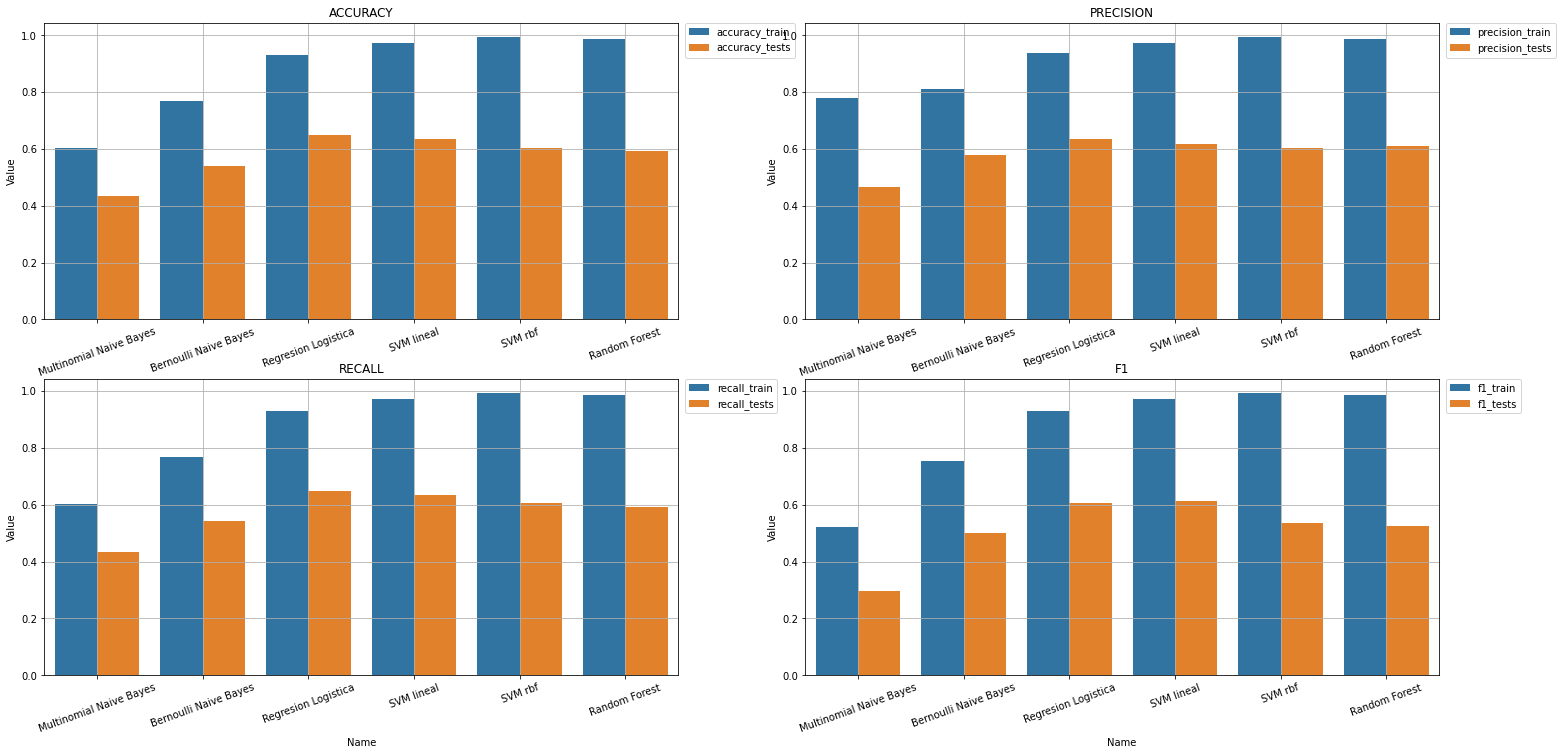

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Métricas a pintar
METRICS = ["accuracy", "precision", "recall", "f1"]

# Transformamos el dataframe para pintar las gráficas con seaborn
df_plot = results.reset_index().melt(id_vars='name').rename(columns=str.title)

plt.figure(figsize=(25, 12))
pos = 1
for metric in METRICS:
    # Filtramos la métrica a pintar
    df_aux = df_plot[df_plot['Variable'].str.contains(metric)]
    
    # Pintamos la gráfica en su posición 2x2
    plt.subplot(2, 2, pos)
    sns.barplot(x='Name', y='Value', hue='Variable', data=df_aux)
    plt.title(metric.upper())
    plt.grid()
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=20)
    pos += 1
plt.show()

* Vamos a dibujar las matrices de confusión obtenidas para cada uno de los modelos creados:

* Para ver como clasifica el modelo generado usamos la denominada ***“Matriz de Confusión”*** en la cual se muestra el número de elementos que clasifica como verdaderos y falsos positivos y verdaderos y falsos negativos.

Obteniendo Matriz de Confusión de: Multinomial Naive Bayes
Obteniendo Matriz de Confusión de: Bernoulli Naive Bayes
Obteniendo Matriz de Confusión de: Regresion Logistica
Obteniendo Matriz de Confusión de: SVM lineal
Obteniendo Matriz de Confusión de: SVM rbf
Obteniendo Matriz de Confusión de: Random Forest


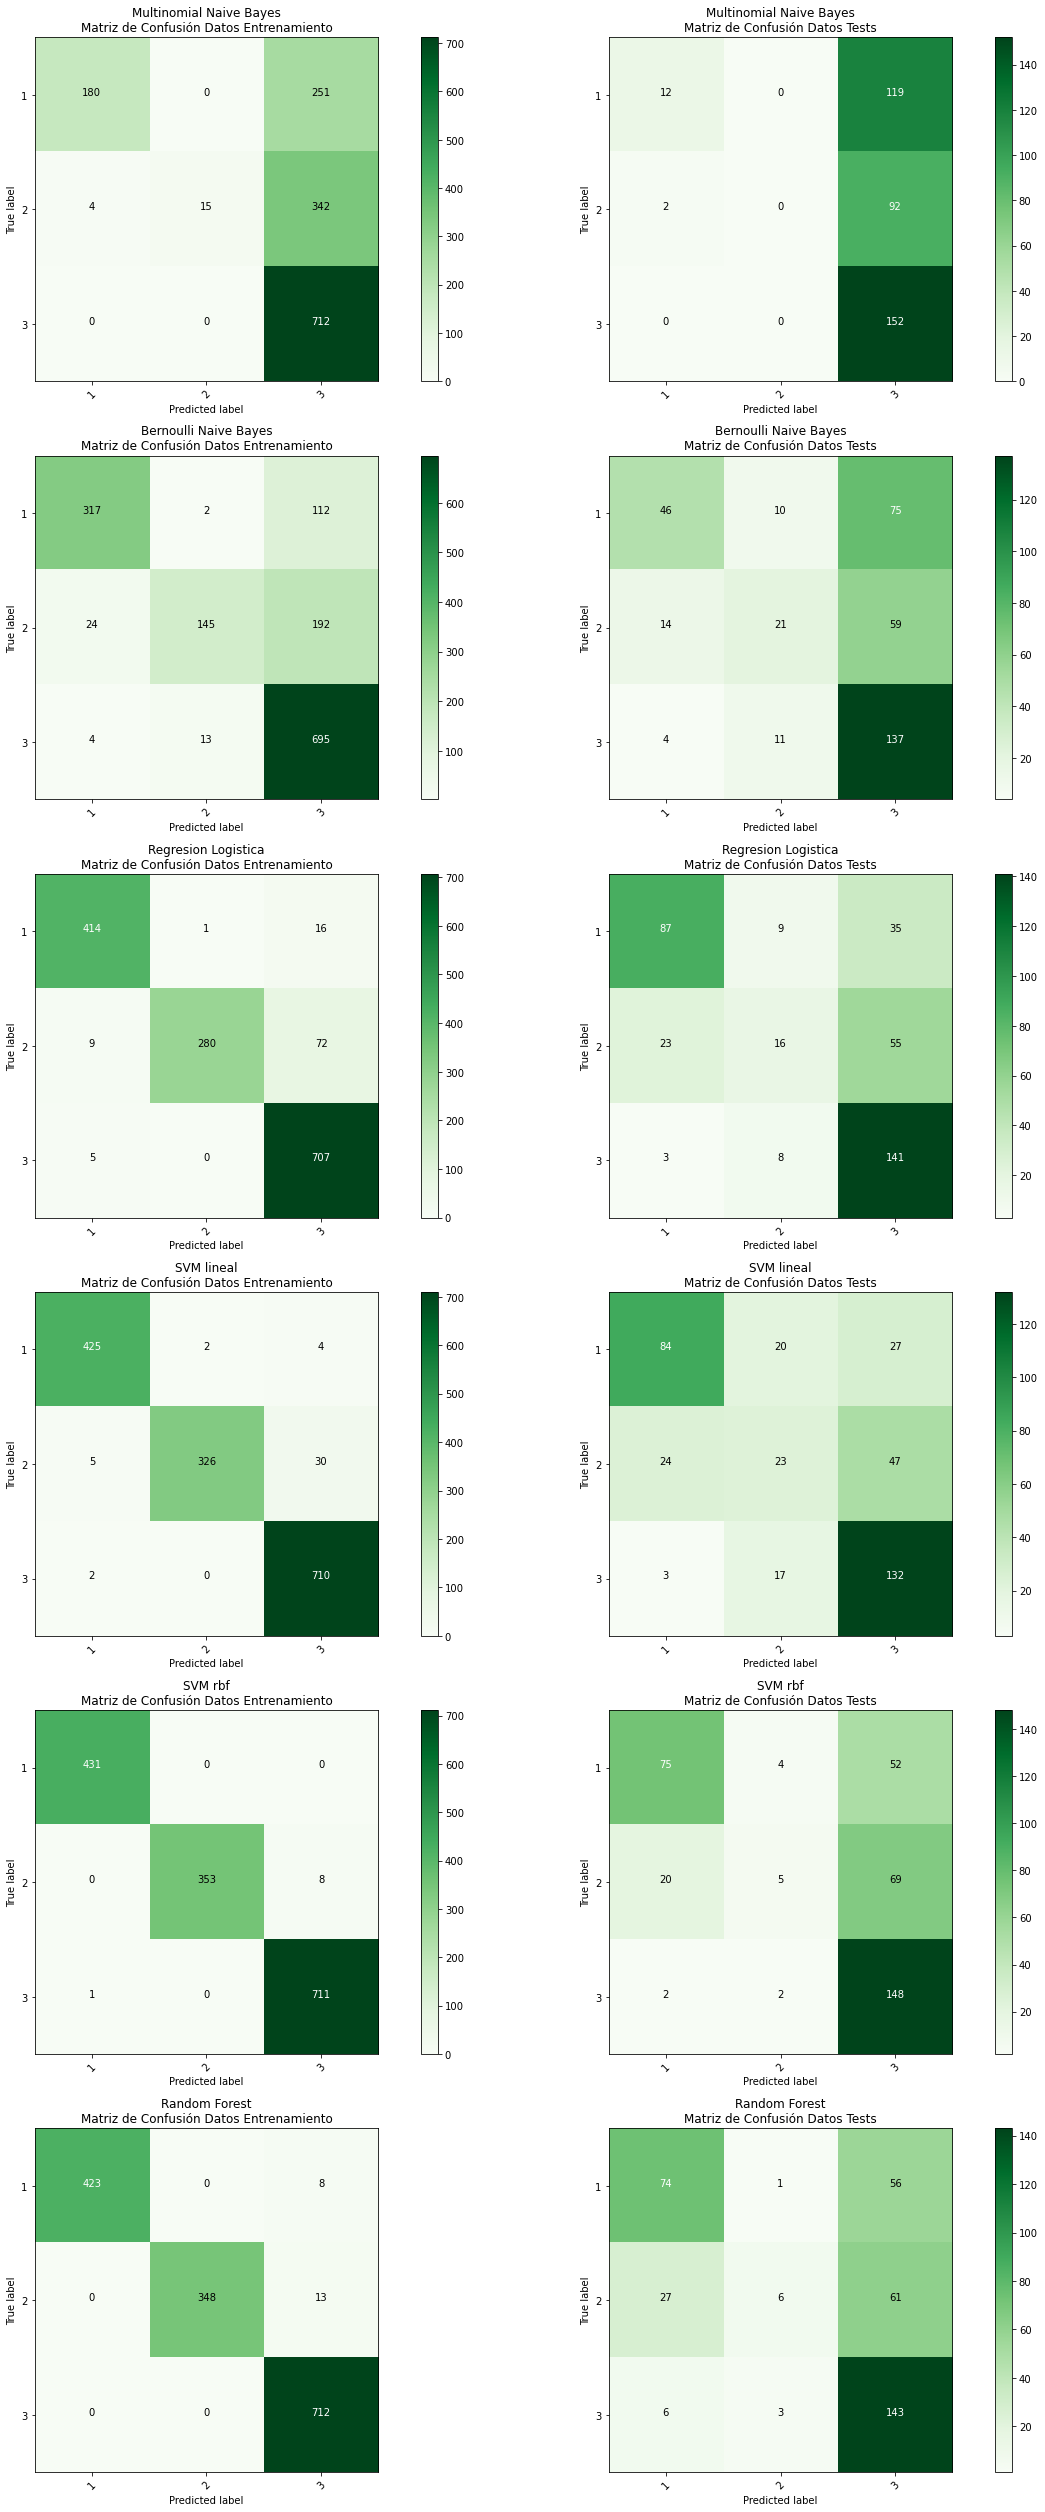

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

from sklearn.metrics import confusion_matrix

sentiment = [1, 2, 3]

# Obtenemos las Matrices de confusión
msc = list()
for k, v in clasificadores.items():
    print ('Obteniendo Matriz de Confusión de: {model}'.format(model=k))
    model = {}
    model['name'] = k
    y_pred_train = v.predict(X_train)
    y_pred_test = v.predict(X_test)
    model['confusion_matrix_train'] = confusion_matrix(y_true=y_train, y_pred=y_pred_train, labels=sentiment)
    model['confusion_matrix_test'] = confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=sentiment)
    msc.append(model)

    
# Definimos el heatmap de la matriz de confusión
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Pintamos las matrices de confusión
plt.figure(figsize=(20, 35))
pos = 0
for mc in msc:
    pos += 1
    plt.subplot(6, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_train'], classes=sentiment, 
                          title='{}\nMatriz de Confusión Datos Entrenamiento'.format(mc['name']))
    pos += 1
    plt.subplot(6, 2, pos)
    plot_confusion_matrix(mc['confusion_matrix_test'], classes=sentiment, 
                          title='{}\nMatriz de Confusión Datos Tests'.format(mc['name'] ))
plt.show()

# Los metodos de clasificacion Regresion Logistica seguido por el SVM me dan mejores resultados en la matriz de confusion, al clasificar negativos y positivos. Los demas modelos bajan la calidad al clasificar estos dos caracteristicas. Sin embargo ninguno es capaz de mejorar la clasificacion para la caracteristica Neutro.